# GCAM Annual Meeting 2023 Tutorial

The purpose of this tutorial is to demonstrate how `stitches` can be used as an emulator. While `stitches` can
 emulate a number of CMIP6 models, this example will focus on emulating CanESM5 SSP245 results.

This tutorial also assumes that the user has either seen a talk on `stitches` or
read the paper published in _Earth System Dyanmics_ (Tebaldi et al 2022). This
tutorial is aimed at highlighting the flexibility of functions in `stitches`.

A simpler quickstart notebook comes in every stitches download:

https://github.com/JGCRI/stitches/blob/main/notebooks/stitches-quickstart.ipynb

Both notebooks assume a familiarity with CMIP-style data.

To use `stitches`, there are a number of decisions users have to make,
perhaps the most important being:

* Which ESM will `stitches` emulate?
* What archive data will be used? These are values that the target data will be matched to. It should only
contain data for the specific ESM that is being emulated. Users may limit the number of experiments or
ensemble realizations within the archive in order to achieve their specific experimental setup.
* What target data will be used? This data frame represents the temperature pathway the stitched product
will follow. The contents of this data frame may come from CMIP6 ESM results for an SSP or it may follow
some arbitrary pathway.

A diagram illustrating the `stitches` process is included for reference:

![stitches workflow](figs/stitches_diagram.jpg)

- `stitches` defaults to $X=9$ year windows.


So, if one were to take smoothed ESM data for many scenarios and plot the
global average temperature, the vertical lines drawn here represents a _potential_
segmenting of the data into those 9 year windows:

![Example Tgav](figs/Tutorial_2023_tgavex.jpg)


In each segment, the median temperature value and the change in value per segment
can be plotted in a two dimensional space:

![Example T, dT](figs/Tutorial_2023_T_dT_example.jpg)

The black points represent a 'target' scenario. This two dimensional space is where
matching to the available archive points (colorful) occurs.


# Getting Started


In [1]:
import stitches


Load the additional python libraries that will be used in this example.
These packages are installed as `stitches` dependencies.

In [2]:
import os
import pkg_resources
import warnings

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt



# For help with plotting
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 6


# Install the package data from Zenodo

The package data is all data that has been processed from raw Pangeo data
 and is generated with package functions. For convenience and rapid cloning
 of the github repository, the package data is also minted on Zenodo and
 can be quickly downloaded for using the package.
 

In [3]:
# stitches.install_package_data()

# Example Set Up

In this example, we will use `stitches` to emulate CanESM5 SSP245 results.
Then we will compare the `stitches` results with actual CMIP6 CanESM5 SSP245
output data. This is our _Target Data_.

For CMIP6 results, Earth system model data runs from 1850-2100 (or 2099,
depending on the ESM). This tutorial will focus on emulating that entire period.

# Decide on the target data
- The primary input to `stitches` functions that most users will adjust is the
target data.

- The target data is the temperature pathway the stitched (emulated) product
will follow. This data can come from an ESM or another class of climate models,
for a specific SSP scenario or an arbitrarily defined scenario. Similarly to the archive
data, the target data should contain the mean temperature anomaly and rate of
temperature change over a window of time.

- The target data window and the archive window must be the same length,
`stitches` uses a 9-year window by default.  `stitches` includes functions for
processing raw ESM  Tgav data into the structure it needs for matching.
- In this example, we will use CanESM5 SSP245 results for a single ensemble
member to use as our target data.

In [4]:
# Load time series and subset to target time series if needed:
data_directory = pkg_resources.resource_filename('stitches', "data")
targ = pd.read_csv(os.path.join(data_directory, "tas-data", "CanESM5_tas.csv"))
target_data = targ.loc[(targ["model"] == "CanESM5")
                       & (targ["experiment"] == 'ssp245')].copy()

target_data  = target_data[target_data["ensemble"].isin(['r1i1p1f1'])].copy()

target_data = target_data.drop(columns='zstore').reset_index(drop=True)

Take a look at the structure and a plot of the time series we will be targeting:

  variable experiment  ensemble    model  year     value
0      tas     ssp245  r1i1p1f1  CanESM5  1850 -1.133884
1      tas     ssp245  r1i1p1f1  CanESM5  1851 -1.389375
2      tas     ssp245  r1i1p1f1  CanESM5  1852 -1.318175
3      tas     ssp245  r1i1p1f1  CanESM5  1853 -1.163771
4      tas     ssp245  r1i1p1f1  CanESM5  1854 -1.302066


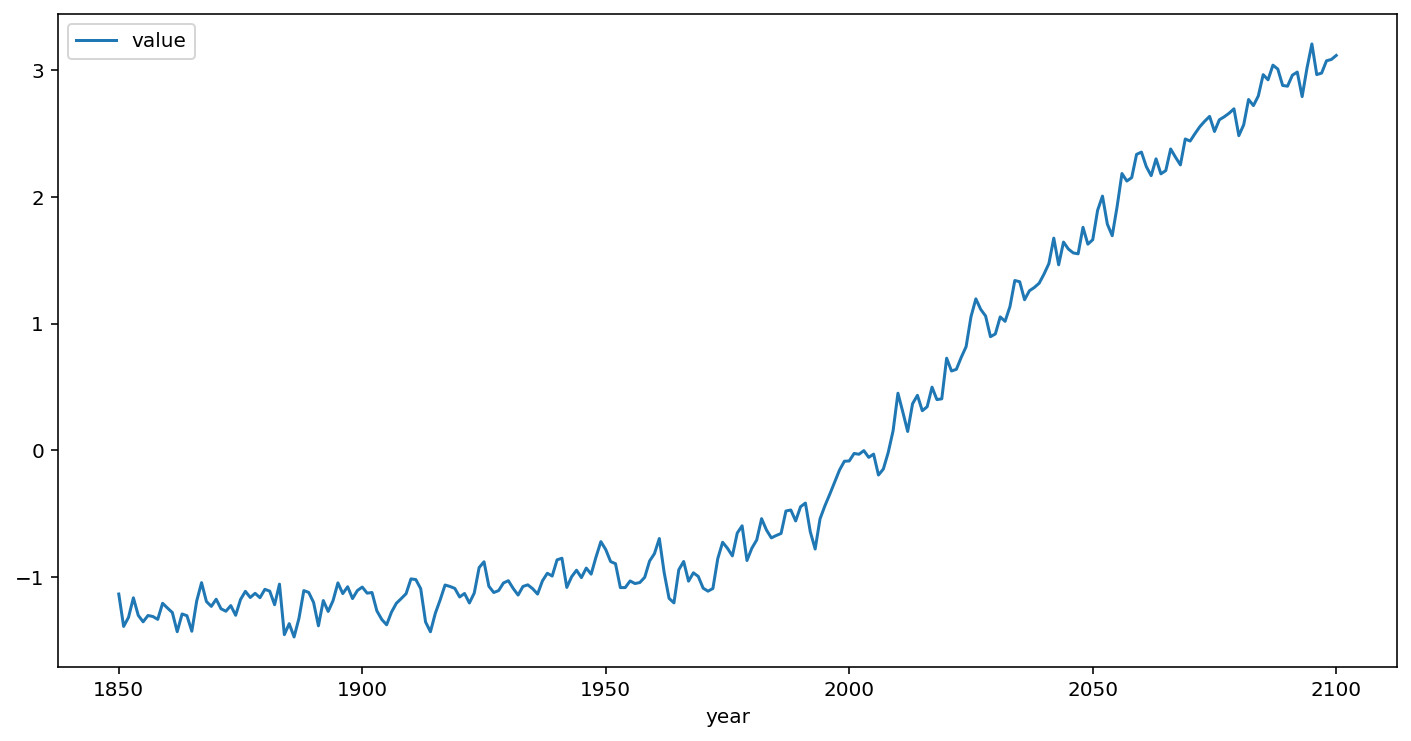

In [5]:
print(target_data.head())
target_data.plot(x='year', y='value')
plt.show()
plt.close()

- Critically, these time series are _global average temperature anomaly from
1995-2014 average_.
- Note that Hector outputs are in terms of anomaly from pre-industrial average,
so Hector outputs will need a shift before being used as targets for stitching.


- Any time series of global average temperature anomalies can be used as a
target. However, the data frame containing this time series must be structured as
above: a `variable` column containing entries of 'tas',  `year` and `value`
columns containing the data, and `experiment`, `ensemble`, `model` columns
with identifying information of the source of this target data.
- The actual entries in the `experiment`, `ensemble`, `model` columns are only
used for generating identifying strings for generated ensemble members.


- In this demonstration, we will specifically be targeting ensemble member 1
of the CanESM5 SSP245 simulations. The entire SSP245 ensemble may be
jointly targeted by omitting the line
`target_data  = target_data[target_data["ensemble"].isin(['r1i1p1f1'])].copy()`

# Decide on the archive data

- Limit the archive matching data to the model we are trying to emulate, CanESM5
in this case.
- In this example, we treat SSP245 as a novel scenario rather than one
run by the ESM and available, so we exclude it from the archive data.
- The internal package data called `matching_archive` contains the temperature
results for all the ESMs-Scenarios-ensemble members that are available for
`stitches` to use in its matching process. In this file monthly, tas output has
been processed to mean temperature anomaly and the temperature change over a
window of time. By default `stitches` uses a 9-year window.

- `stitches` actually provides two files in its pacakge data.
- `matching_archive.csv` can be considered the default (for now). Starting in
1850, nine year windows are sliced forward and don't overlap.
- The final window ends up beginning in 2093, and is only 8 years long to
terminate in 2100 (7 years if the ESM ends in 2099).
- When an 8 year archive window gets matched to a 9 year target window,
`stitches` repeats the final archive window year to get to 9 years.
- For ESMs that end in 2099, the 2093-2099 seven-year window must be omitted

- That means that we lose some of the most interesting differences between
scenarios.
- Therefore, `stitches` includes `matching_archive_staggered.csv` as package
data as well. The difference is that this file does every possible full 9-year chunk,
not just slicing sequentially from the starting point.
- We have to do a little more pre-processing for the archive data, but it offers
more flexibility and robustness.
- The `stitches_quickstart` notebook that ships with the package uses the
default `matching_archive.csv` and is generally a shorter version of this tutorial.

In [6]:
# read in the package data of all ESMs-Scenarios-ensemble members avail.
data_directory = pkg_resources.resource_filename('stitches', "data")
path = os.path.join(data_directory, 'matching_archive_staggered.csv')
data = pd.read_csv(path)


# Extra preprocessing for `matching_archive_staggered.csv`
Let's start from the final ESM year, 2100 for CanESM5, and prioritize getting that
as a full 9 year window. Short windows can be on the front end.

- if the final year for an ESM is 2099, you'd just do
`end_yr_vector = end_yr_vector-1` to shift everything up a year.

In [7]:
staggered_archive = data.copy()

end_yr_vector = [1857, 1866, 1875,1884, 1893,
                 1902, 1911, 1920, 1929, 1938, 1947,
                 1956,  1965, 1974, 1983, 1992, 2001,
                 2010, 2019, 2028, 2037, 2046, 2055,
                 2064, 2073, 2082, 2091, 2100]

tmp = staggered_archive.loc[(data["experiment"].isin(['ssp126', 'ssp370', 'ssp585']))
                       & (data["model"] == "CanESM5")].copy()
archive_data = stitches.fx_processing.subset_archive(staggered_archive = tmp,
                                            end_yr_vector = end_yr_vector)

print(archive_data)

     experiment variable    model   ensemble  start_yr  end_yr  year  \
0        ssp126      tas  CanESM5  r10i1p1f1      1858    1866  1862   
1        ssp126      tas  CanESM5  r10i1p1f1      1867    1875  1871   
2        ssp126      tas  CanESM5  r10i1p1f1      1876    1884  1880   
3        ssp126      tas  CanESM5  r10i1p1f1      1885    1893  1889   
4        ssp126      tas  CanESM5  r10i1p1f1      1894    1902  1898   
...         ...      ...      ...        ...       ...     ...   ...   
2020     ssp585      tas  CanESM5   r9i1p1f1      2056    2064  2060   
2021     ssp585      tas  CanESM5   r9i1p1f1      2065    2073  2069   
2022     ssp585      tas  CanESM5   r9i1p1f1      2074    2082  2078   
2023     ssp585      tas  CanESM5   r9i1p1f1      2083    2091  2087   
2024     ssp585      tas  CanESM5   r9i1p1f1      2092    2100  2096   

            fx        dx  
0    -1.299509 -0.001848  
1    -1.225040  0.010931  
2    -1.205325 -0.012385  
3    -1.299790  0.004692  


The staggered archive ONLY has 9 year windows, no short windows. So no window
from 1850-1857 exists to get pulled for that `end_yr`.
The historical period is so consistent, there are plenty of other full sized (9year)
windows that have similar properties and can make for a good match, so we aren't
really losing anything by not having archive points representing 1850-1857.
If we really want, we can go ahead and have an 1850-1858 window in the archive
by just replacing 1857 with 1858 in the above. There will be one year (1858) in
common between that new window and the one ending in 1866 but that's not
an amount of similarity that would lead to unrealistic behavior like if we used
all of the entries in the staggered archive.

And that would look like:

In [8]:
end_yr2 = [1858, 1866, 1875,1884, 1893,
           1902, 1911, 1920, 1929, 1938, 1947,
           1956,  1965, 1974, 1983, 1992, 2001,
           2010, 2019, 2028, 2037, 2046, 2055,
           2064, 2073, 2082, 2091, 2100]
archive_data = stitches.fx_processing.subset_archive(staggered_archive = tmp,
                                      end_yr_vector = end_yr2).sort_values(by=['experiment', 'ensemble', 'end_yr'])
print(archive_data)

     experiment variable    model   ensemble  start_yr  end_yr  year  \
0        ssp126      tas  CanESM5  r10i1p1f1      1850    1858  1854   
75       ssp126      tas  CanESM5  r10i1p1f1      1858    1866  1862   
76       ssp126      tas  CanESM5  r10i1p1f1      1867    1875  1871   
77       ssp126      tas  CanESM5  r10i1p1f1      1876    1884  1880   
78       ssp126      tas  CanESM5  r10i1p1f1      1885    1893  1889   
...         ...      ...      ...        ...       ...     ...   ...   
2095     ssp585      tas  CanESM5   r9i1p1f1      2056    2064  2060   
2096     ssp585      tas  CanESM5   r9i1p1f1      2065    2073  2069   
2097     ssp585      tas  CanESM5   r9i1p1f1      2074    2082  2078   
2098     ssp585      tas  CanESM5   r9i1p1f1      2083    2091  2087   
2099     ssp585      tas  CanESM5   r9i1p1f1      2092    2100  2096   

            fx        dx  
0    -1.360399  0.016472  
75   -1.299509 -0.001848  
76   -1.225040  0.010931  
77   -1.205325 -0.012385  


This is what we will go ahead and use for our archive data.

- There is one year of  data (1858) that gets shared between two archive windows.
- Therefore it is possible to get a year of data repeated in the stitched outputs.
- This is no worse than the default archive, and possibly better to have it happen
in the period before the SSPs really diverge.
- In general, you don't want many shared years between archive windows, or
unrealistic behavior can occur.

# Target data pre-processing
- We had decided to target SSP245 realization 1 to emulate
- Our archive is set up with 9 year chunks, and we prioritized having a full 9 year
window ending in 2100 and working backward for that data.
- We can do the same thing for our target data.
- The target data doesn't necessarily have to have the same length as the
archive trajectory.
- It does benefit, however, from being a multiple of 9 long, although having an
8 year window in the target is fine as well.

- Shorter windows in the target are also fine from the perspective of the method,
we just haven't coded it cleanly yet.


Regardless, the first step of pre-processing any target data is to smooth it.
- even Hector outputs, which are already quite smooth, require this.

In [9]:
target_data = stitches.fx_processing.calculate_rolling_mean(target_data,
                                                            size=31).copy()

The default chunking, starting with 1850 and cutting every 9 years after that.
This results in the final window only being 8 years. That is fine, a target window
that is only 1 year short is not a problem.

In [10]:
target_data1 = stitches.fx_processing.get_chunk_info(
    stitches.fx_processing.chunk_ts(df = target_data,  n=9)).copy()
print(target_data1)

   experiment variable    model  ensemble  start_yr  end_yr  year        fx  \
0      ssp245      tas  CanESM5  r1i1p1f1      1850    1858  1854 -1.272611   
1      ssp245      tas  CanESM5  r1i1p1f1      1859    1867  1863 -1.250102   
2      ssp245      tas  CanESM5  r1i1p1f1      1868    1876  1872 -1.243684   
3      ssp245      tas  CanESM5  r1i1p1f1      1877    1885  1881 -1.204998   
4      ssp245      tas  CanESM5  r1i1p1f1      1886    1894  1890 -1.197851   
5      ssp245      tas  CanESM5  r1i1p1f1      1895    1903  1899 -1.213103   
6      ssp245      tas  CanESM5  r1i1p1f1      1904    1912  1908 -1.170853   
7      ssp245      tas  CanESM5  r1i1p1f1      1913    1921  1917 -1.145708   
8      ssp245      tas  CanESM5  r1i1p1f1      1922    1930  1926 -1.086683   
9      ssp245      tas  CanESM5  r1i1p1f1      1931    1939  1935 -1.012161   
10     ssp245      tas  CanESM5  r1i1p1f1      1940    1948  1944 -0.986856   
11     ssp245      tas  CanESM5  r1i1p1f1      1949 

For consistency with how we set up the archive, however, we will have  the target
window ending in 2100 be a complete 9 years and work back.

You can use the `base_chunk=8` argument to do that. The previous call starting
in 1850 and cutting every 9 years aftere that uses the default `base_chunk=0`.
`base_chunk=8` means the target starts in 1850+8 = 1858 and cuts every 9
years after that, ending in 2100.

If the ESM data ends in 2099 and you wanted the target window ending in 2099
to be a complete 9 year window, you'd use `base_chunk=7`. It's a little clunky and
we could certainly make it more interpretable/flexible, but it's not too bad to
figure out for now hopefully.

In [11]:
target_data2 = stitches.fx_processing.get_chunk_info(
    stitches.fx_processing.chunk_ts(df = target_data,  n=9,
                                    base_chunk=8)).copy()
print(target_data2)

   experiment variable    model  ensemble  start_yr  end_yr  year        fx  \
0      ssp245      tas  CanESM5  r1i1p1f1      1858    1866  1862 -1.254450   
1      ssp245      tas  CanESM5  r1i1p1f1      1867    1875  1871 -1.242954   
2      ssp245      tas  CanESM5  r1i1p1f1      1876    1884  1880 -1.214581   
3      ssp245      tas  CanESM5  r1i1p1f1      1885    1893  1889 -1.195424   
4      ssp245      tas  CanESM5  r1i1p1f1      1894    1902  1898 -1.200969   
5      ssp245      tas  CanESM5  r1i1p1f1      1903    1911  1907 -1.172773   
6      ssp245      tas  CanESM5  r1i1p1f1      1912    1920  1916 -1.145221   
7      ssp245      tas  CanESM5  r1i1p1f1      1921    1929  1925 -1.091947   
8      ssp245      tas  CanESM5  r1i1p1f1      1930    1938  1934 -1.022043   
9      ssp245      tas  CanESM5  r1i1p1f1      1939    1947  1943 -0.994382   
10     ssp245      tas  CanESM5  r1i1p1f1      1948    1956  1952 -0.955606   
11     ssp245      tas  CanESM5  r1i1p1f1      1957 

if you really don't want to sacrifice the 1850-1857 years in the stitched outputs,
 you can get kind of clunky and play around with the `chunk_ts` arguments to get
 an 1850-1857 chunk and just append that to the target data

In [12]:
short_target_window = stitches.fx_processing.get_chunk_info(
    stitches.fx_processing.chunk_ts(df = target_data,  n=8,
                                    base_chunk=0)).copy()

short_target_window = short_target_window[short_target_window['end_yr'] == 1857].copy()

print(short_target_window)

  experiment variable    model  ensemble  start_yr  end_yr  year        fx  \
0     ssp245      tas  CanESM5  r1i1p1f1      1850    1857  1854 -1.272611   

        dx  
0  0.00468  


In [13]:
target_data3 = pd.concat([short_target_window, target_data2]).reset_index(drop=True).copy()
print(target_data3)

   experiment variable    model  ensemble  start_yr  end_yr  year        fx  \
0      ssp245      tas  CanESM5  r1i1p1f1      1850    1857  1854 -1.272611   
1      ssp245      tas  CanESM5  r1i1p1f1      1858    1866  1862 -1.254450   
2      ssp245      tas  CanESM5  r1i1p1f1      1867    1875  1871 -1.242954   
3      ssp245      tas  CanESM5  r1i1p1f1      1876    1884  1880 -1.214581   
4      ssp245      tas  CanESM5  r1i1p1f1      1885    1893  1889 -1.195424   
5      ssp245      tas  CanESM5  r1i1p1f1      1894    1902  1898 -1.200969   
6      ssp245      tas  CanESM5  r1i1p1f1      1903    1911  1907 -1.172773   
7      ssp245      tas  CanESM5  r1i1p1f1      1912    1920  1916 -1.145221   
8      ssp245      tas  CanESM5  r1i1p1f1      1921    1929  1925 -1.091947   
9      ssp245      tas  CanESM5  r1i1p1f1      1930    1938  1934 -1.022043   
10     ssp245      tas  CanESM5  r1i1p1f1      1939    1947  1943 -0.994382   
11     ssp245      tas  CanESM5  r1i1p1f1      1948 

# Emulate
- now that you are empowered to process almost any data into an archive and a
target, we can emulate.

- This occurs with two functions:
- `stitches.make_recipe()` does the matching between a target and archive,
and gives the pointers to all of the pangeo-hosted netcdf files of data.
- `stitches.gmat_stitching()` or `stitches.gridded_stitching()` then stitch either
global average temperature anomaly  trajectories or gridded, multivariate netcdfs
from those recipes.

# Matching and making the recipe.
The arguments for making recipes are relatively simple. You specify the
target data, the archive data, how many matches you want to try to make for
each realization of the target data, and whether you want your results to be
reproducible.

Two other optional variables include
- `non_tas_variables` - which variables in addition to tas do you think you want to
have gridded results for? The default is to only provide tas recipes.
- `res` - do you want to stitch monthly (`'mon'`) or daily (`'day'`) gridded
results? The default is to monthly as daily files are very large to work with and
create.


Within `make_recipe`, two steps are happening:
 1. matching - identifying possible archive window matches for each target window
 2. permuting - random combinations of those potential matches are drawn to
create stitched time series. These draws control for 'envelope collapse', where
the same archive window gets used in the same place for many generated
ensemble members.

The remaining argument, `tol` specifies the matching tolerance - for each target
window, how far out away in the archive are we willing to look for similar points?
- `stitches` prioritizes providing a nearest neighbor match, which dictates how it
currently uses `tol`
- `tol=0.0` corresponds to providing the nearest neighbor match.
- Each target window gets its own, custom nearest neighbor match that is some
distance away, `dist_nn`.
- For each target window, we center a circular matching neighborhood on the
target point. In a radius of `dist_nn`, we know the nearest neighbor is the only
available point by definition.
- Therefore, we expand the matching neighborhood for each target point to
search for matches up to a distance of `dist_nn + tol` away.
- So if target window A has a nearest neighbor 0.1degC away, and `tol=0.01`,
then a circle centered on A with radius 0.11degC contains all possible matches.
If target window B has a nearest neighbor 0.05degC away, then its matching
neighborhood is a circle centered on B with a radius of 0.06degC.


- We do this because when doing random draws of all possible combinations of
collapse-free ensembles from a set of potential matches, formatting the matching
in this way turns finding a cutoff tolerance value for each ESM into a min-max
problem that's a little easier to calculate.

- In the paper, we provide `z_cutoff` values that are 'safe' maximum tolerances
to use for every ESM examined. We will be adding more ESMs in the future.

In [14]:
# the nearest neighbor recipes
nn_recipes = stitches.make_recipe(target_data = target_data3,
                                  archive_data=archive_data,
                                  tol=0.0,
                                  N_matches=4,
                                  reproducible=True)
print(nn_recipes.head())

You have requested more recipes than possible for at least one target trajectories, returning what can
The following target windows have a nearest neighbor in T, dT space
that is more than 0.25degC away. This may or may not result in poor
matches and we recommend validation.
  target_variable target_experiment target_ensemble target_model  \
0             tas            ssp245        r1i1p1f1      CanESM5   

   target_start_yr  target_end_yr  target_year  target_fx  target_dx  \
0             2083           2091         2087   2.832238   0.012831   

  archive_experiment  ... archive_model archive_ensemble archive_start_yr  \
0             ssp370  ...       CanESM5        r17i1p1f1             2056   

   archive_end_yr  archive_year  archive_fx  archive_dx   dist_dx   dist_fx  \
0            2064          2060    2.815717    0.045724  0.263149  0.016521   

    dist_l2  
0  0.263667  

[1 rows x 21 columns]
-----------------------------------------------------------------------------

Depending on the version of stitches being used, you might  get a print statement
saying

`The following target windows have a nearest neighbor in T, dT space
that is more than 0.25degC away. This may or may not result in poor
matches and we recommend validation.`

This is a flat check we are implementing on our development branch - if any
the nearest neighbor matches for any target window are more than 0.25degC
away, then this statement is printed with the target window's details.

This does not necessarily mean anything is wrong and this flag can be printed in
runs that have been validated extremely well.

Iit just means that the target trajectory may not be similar enough for the
selected archive of data points, and validation is warranted. `stitches` is a
constructive method and generally any generated ensemble should be validated
against the training data.
This is why we pre-calculate the tolerance cutoff values for each ESM in the ESD
paper, to save effort validating future generated ensembles.

In [15]:
# additional recipes
my_recipes = stitches.make_recipe(target_data = target_data3,
                                  archive_data=archive_data,
                                  tol=0.05,
                                  res='mon',
                                   non_tas_variables=['pr'],
                                  N_matches=4,
                                  reproducible=True)
print(my_recipes.head())
print('-----------------------------------')
# you can take a look at one of the actual file addresses to get a sense of
# what the Pangeo file addresses look like.:
print(my_recipes['pr_file'].iloc[0])

You have requested more recipes than possible for at least one target trajectories, returning what can
  target_start_yr target_end_yr archive_experiment archive_variable  \
0            1850          1857         historical              tas   
1            1858          1866         historical              tas   
2            1867          1875         historical              tas   
3            1876          1884         historical              tas   
4            1885          1893         historical              tas   

  archive_model archive_ensemble       stitching_id archive_start_yr  \
0       CanESM5         r5i1p1f1  ssp245~r1i1p1f1~1             1912   
1       CanESM5        r22i1p1f1  ssp245~r1i1p1f1~1             1921   
2       CanESM5        r12i1p1f1  ssp245~r1i1p1f1~1             1921   
3       CanESM5         r7i1p1f1  ssp245~r1i1p1f1~1             1858   
4       CanESM5         r2i1p1f1  ssp245~r1i1p1f1~1             1912   

  archive_end_yr                     

If you wanted to include sea level pressure in addition to precipitation, you would use
`non_tas_variables=['pr', 'psl']`.


# stitching and plotting

## Nearest neighbor result
Stitch the global average temperature for the nearest neighbor result,
and see it in the context of the actual ESM data that was not used in the archive
at all.

In [16]:
stitched_global_temp = stitches.gmat_stitching(nn_recipes)

### nearest neighbor stitched realization

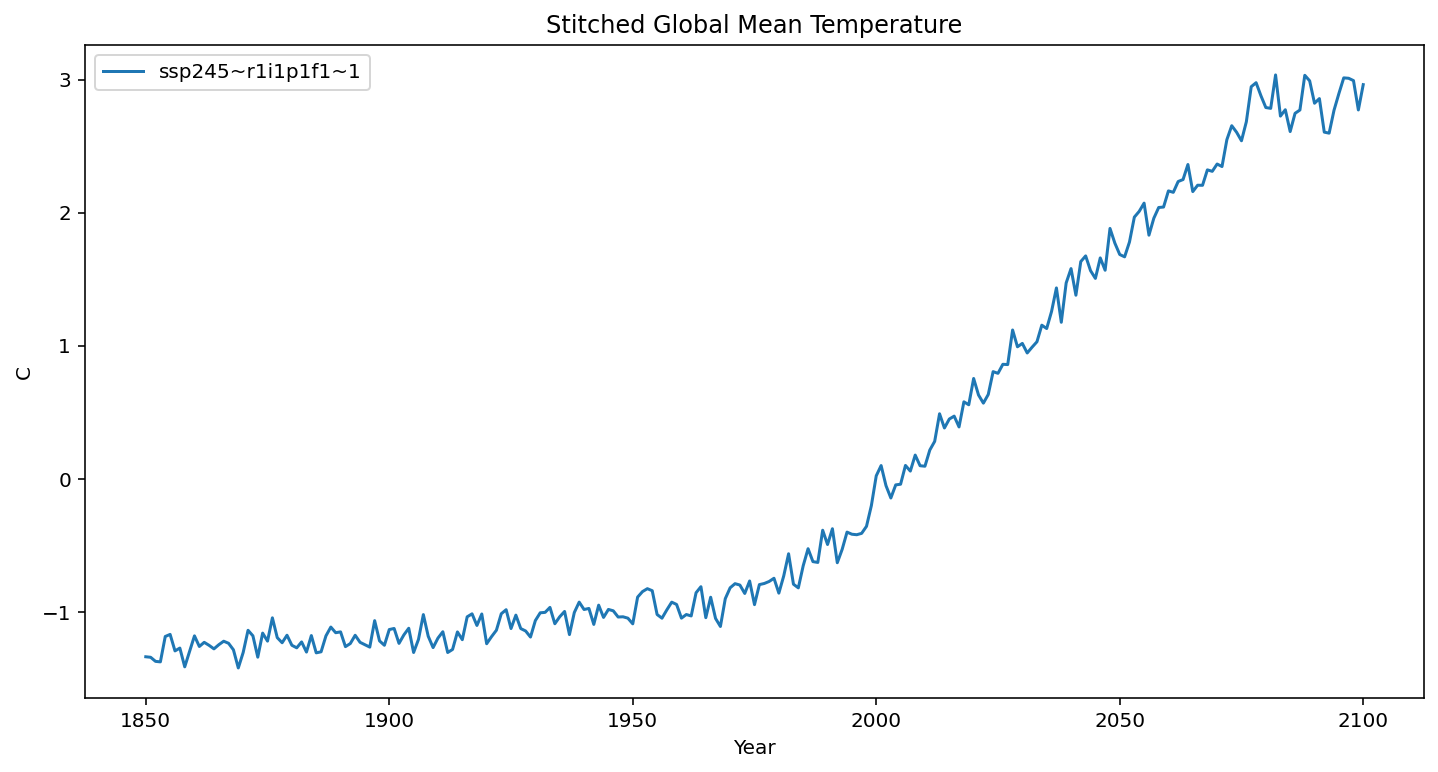

In [17]:
groups = stitched_global_temp.groupby('stitching_id')

for name, group in groups:
    plt.plot(group.year, group.value, label = name)

plt.xlabel("Year")
plt.ylabel("C")
plt.title("Stitched Global Mean Temperature")
plt.legend()
plt.show()
plt.close()



# Load the comparison GSAT data
data_directory = pkg_resources.resource_filename("stitches", "data")
data_path = os.path.join(data_directory, "tas-data", "CanESM5_tas.csv")

comp_data = pd.read_csv(data_path)
comp_data = comp_data.loc[comp_data["experiment"] == "ssp245"]


### stitched realization and the target ensemble member

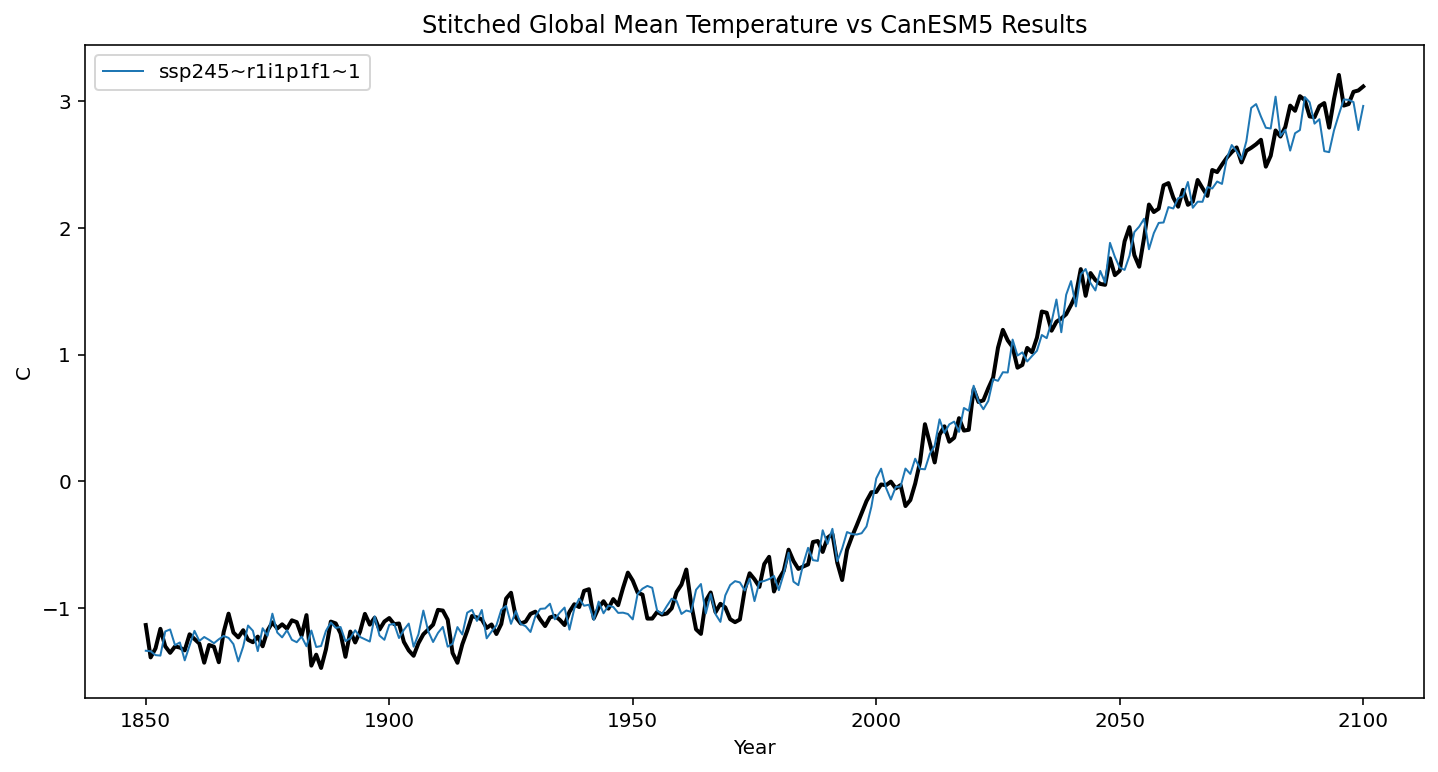

In [18]:
groups = comp_data.groupby('ensemble')
for name, group in groups:
    if(group.ensemble.unique() == 'r1i1p1f1'):
        plt.plot(group.year, group.value, color = "black", linewidth = 2.0)
# The stitched realizations:
groups = stitched_global_temp.groupby('stitching_id')
for name, group in groups:
    plt.plot(group.year, group.value, linewidth= 1.0, label = name)

plt.legend()
plt.xlabel("Year")
plt.ylabel("C")
plt.title("Stitched Global Mean Temperature vs CanESM5 Results")
plt.show()
plt.close()

### stitched realization and the entire scenario ensemble

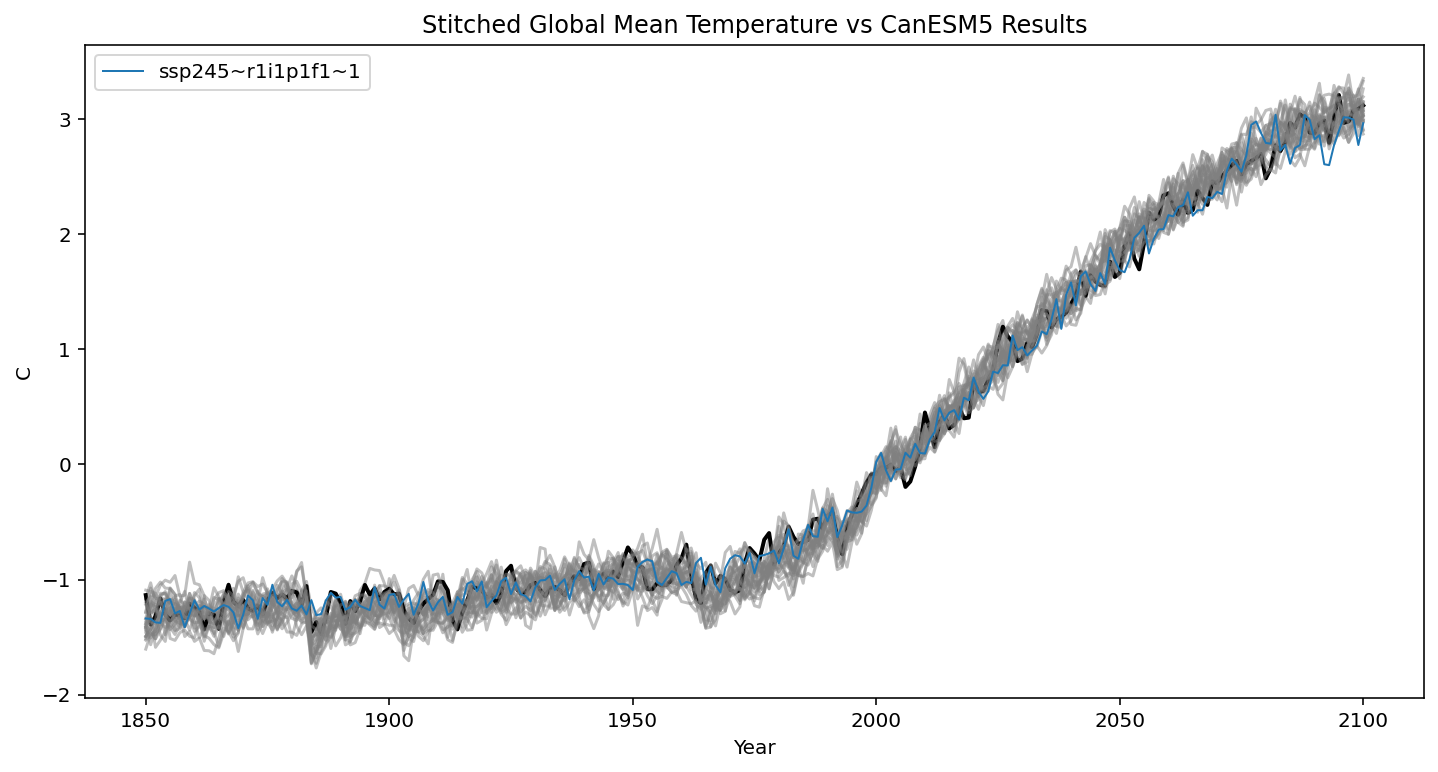

In [19]:
# full ensemble of actual ESM runs:
groups = comp_data.groupby('ensemble')
for name, group in groups:
    if(group.ensemble.unique() == 'r1i1p1f1'):
        plt.plot(group.year, group.value, color = "black", linewidth = 2.0)
    else:
        plt.plot(group.year, group.value, color = "0.5", alpha=0.5)

# The stitched realizations:
groups = stitched_global_temp.groupby('stitching_id')
for name, group in groups:
    plt.plot(group.year, group.value, linewidth= 1.0, label = name)

plt.legend()
plt.xlabel("Year")
plt.ylabel("C")
plt.title("Stitched Global Mean Temperature vs CanESM5 Results")
plt.show()
plt.close()

# gridded stitching of the non-NN recipes

This is a little slow, but it will create the netcdfs according to our stitched recipes
that we can load in and work with.

In [20]:
stitches.gridded_stitching(out_dir='.',  rp=my_recipes)

['Stitching gridded netcdf for: CanESM5 tas ssp245~r1i1p1f1~1']
['Stitching gridded netcdf for: CanESM5 tas ssp245~r1i1p1f1~2']
['Stitching gridded netcdf for: CanESM5 tas ssp245~r1i1p1f1~3']


['./stitched_CanESM5_tas_ssp245~r1i1p1f1~3.nc',
 './stitched_CanESM5_pr_ssp245~r1i1p1f1~3.nc']

now you have created multiple gridded, monthly tas and pr files that are
statistically consistent with the target: SSP245 realization 1.

In [21]:
import xarray as xr

gen_tas = xr.open_dataset('stitched_CanESM5_tas_ssp245~r1i1p1f1~1.nc')
gen_tas


<xarray.Dataset>
Dimensions:  (time: 3012, lat: 64, lon: 128)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2100-12-31
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Data variables:
    tas      (time, lat, lon) float32 ...

In [22]:
gen_pr = xr.open_dataset('stitched_CanESM5_pr_ssp245~r1i1p1f1~1.nc')
gen_pr


<xarray.Dataset>
Dimensions:  (time: 3012, lat: 64, lon: 128)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2100-12-31
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Data variables:
    pr       (time, lat, lon) float32 ...

# Pull comparison netcdfs

In [23]:
# Fetch the actual data directly from pangeo
data_directory = pkg_resources.resource_filename("stitches", "data")
pangeo_path = os.path.join(data_directory, "pangeo_table.csv")

pangeo_data = pd.read_csv(pangeo_path)

pangeo_data = pangeo_data.loc[(pangeo_data['variable'].isin(['tas', 'pr']))
                              & (pangeo_data['domain'].str.contains('mon'))
                              & (pangeo_data['experiment'].isin(['ssp245']))
                              & (pangeo_data['ensemble'].isin(['r1i1p1f1']))
                              & (pangeo_data['model'].isin(['CanESM5']))].copy()

# load the target tas netcdf files
tas_address = pangeo_data.loc[pangeo_data['variable']== 'tas'].zstore.copy()
tar_tas = stitches.fetch_nc(tas_address.values[0])

# load the target pr netcdf files
pr_address = pangeo_data.loc[pangeo_data['variable']== 'pr'].zstore.copy()
tar_pr = stitches.fetch_nc(pr_address.values[0])


# Visualize

Select a grid cell and plot the generated and target tas, pr data for first-cut comparison

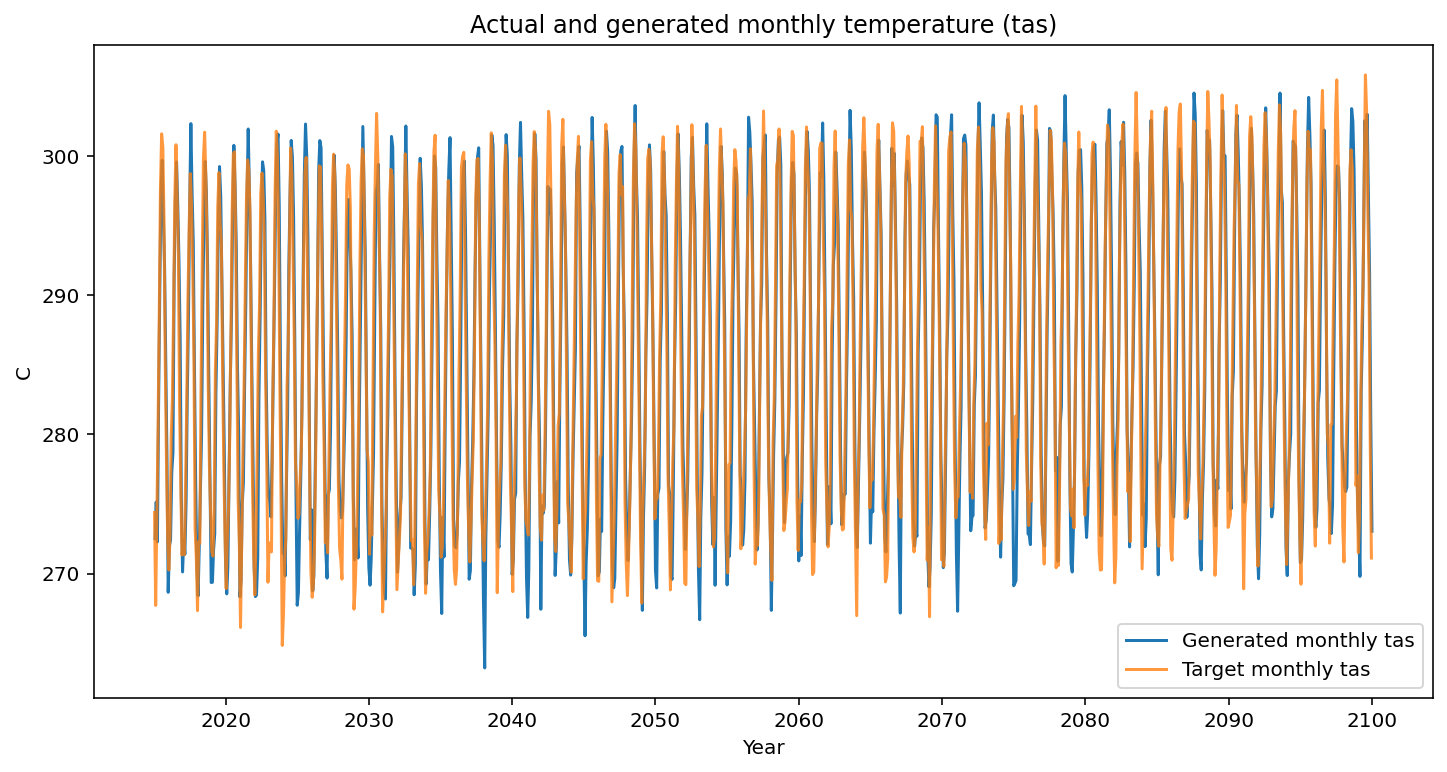

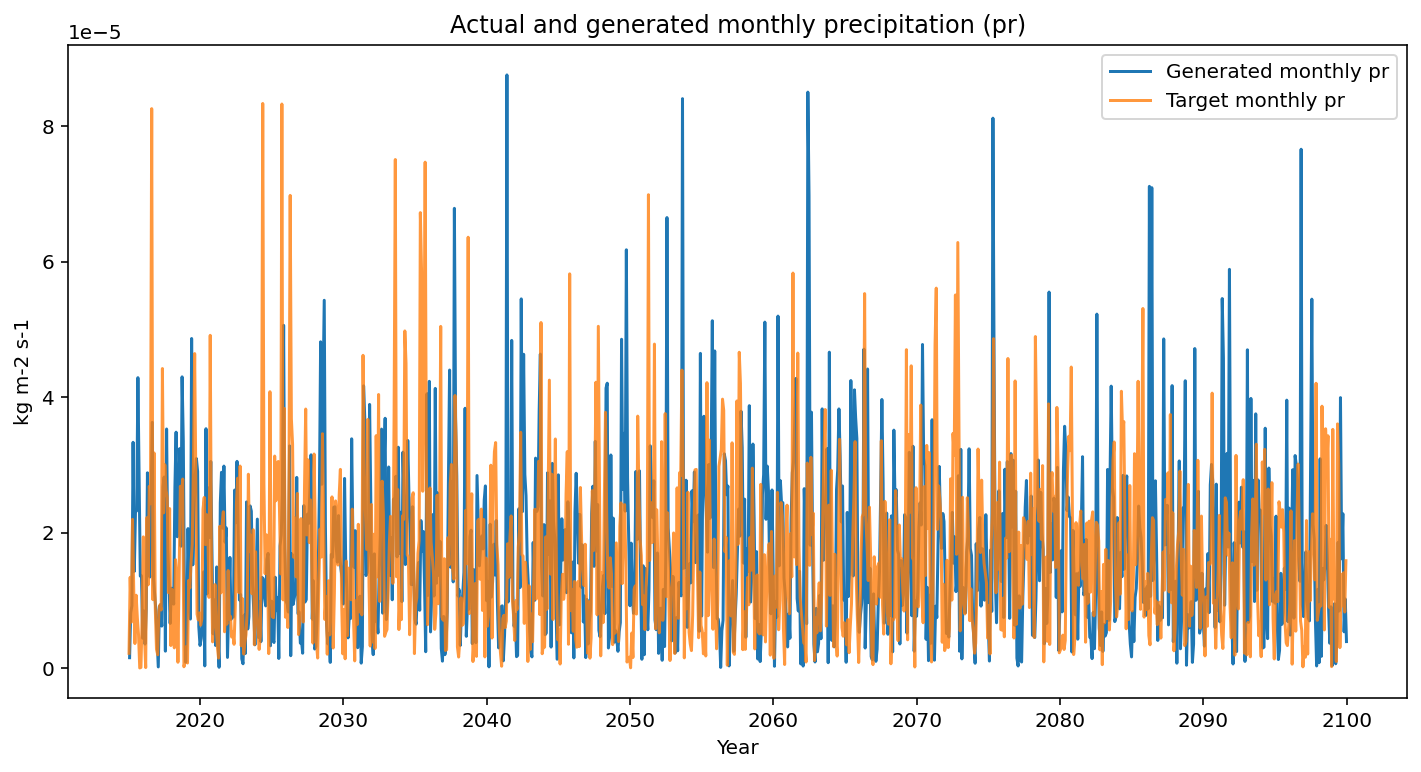

In [24]:
# define a helper function
def plot_comparison(generated_data,
                    target_data,
                    variable,
                    alpha=0.8):
    """Plot comparision between target variable time series and generated data"""

    if variable.casefold() == "pr":
        variable_name = "precipitation"
        units = "kg m-2 s-1"
    else:
        variable_name = "temperature"
        units = "C"

    # temperature (tas)
    plt.plot(generated_data.time,
             generated_data[variable],
             label=f"Generated monthly {variable}")

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")

        plt.plot(target_data.indexes['time'].to_datetimeindex(),
                 target_data[variable],
                 alpha=alpha,
                 label = f"Target monthly {variable}")

    plt.legend()
    plt.xlabel("Year")
    plt.ylabel(units)
    plt.title(f"Actual and generated monthly {variable_name} ({variable})")
    plt.show()
    plt.close()


# lon and lat values for a grid cell near the Joint Global Change Research Institute in College Park, MD, USA
cp_lat = 38.9897
cp_lon = 180 + 76.9378

# lat and lon coordinates closest
abslat = np.abs(gen_tas.lat - cp_lat)
abslon = np.abs(gen_tas.lon-cp_lon)
c = np.maximum(abslon, abslat)
([lon_loc], [lat_loc]) = np.where(c == np.min(c))
lon_grid = gen_tas.lon[lon_loc]
lat_grid = gen_tas.lat[lat_loc]

cp_tas_gen = gen_tas.sel(lon=lon_grid,
                         lat=lat_grid,
                         time=slice('2015-01-01', '2099-12-31')).copy()

cp_tas_tar = tar_tas.sel(lon=lon_grid,
                         lat=lat_grid,
                         time=slice('2015-01-01', '2099-12-31')).copy()

cp_pr_gen = gen_pr.sel(lon=lon_grid,
                       lat=lat_grid,
                       time=slice('2015-01-01', '2099-12-31')).copy()

cp_pr_tar = tar_pr.sel(lon=lon_grid,
                       lat=lat_grid,
                       time=slice('2015-01-01', '2099-12-31')).copy()

# temperature (tas)
plot_comparison(generated_data=cp_tas_gen,
                target_data=cp_tas_tar,
                variable="tas")

# precipitation (pr)
plot_comparison(generated_data=cp_pr_gen,
                target_data=cp_pr_tar,
                variable="pr")

Visual validation of the complex spatial, temporal, and cross-variable
relationships present in ESM outputs is not possible. We extensively validate
that the method reproduces ESM internal variability in the ESD paper, but this
visual plotting at least suggests that nothing is obviously wrong. In particular,
there are no obvious artifacts occurring every 9-years in the generated time
series.


In other words, it's not inconceivable from these plots that the orange time
series were sampled from the same underlying multivariate distribution that
generated the blue time series.

# Draws of collapse-free generated ensembles

As mentioned above, we restrict the generated ensembles of recipes so that they
do not undergo envelope collapse.

Multiple stochastic draws of such ensembles can, however, be made by turning
off the `reproducible` argument.  If these draws of well-behaved ensembles
were concatenated into a 'super' ensemble, there WOULD be envelope collapse.

In [25]:
draw1_recipes = stitches.make_recipe(target_data = target_data3,
                                  archive_data=archive_data,
                                  tol=0.05,
                                  N_matches=4,
                                  reproducible=True)

draw2_recipes= stitches.make_recipe(target_data = target_data3,
                                  archive_data=archive_data,
                                  tol=0.05,
                                  N_matches=4,
                                  reproducible=False)
# stitch tgav
stitched_global_temp_draw1 = stitches.gmat_stitching(draw1_recipes)
stitched_global_temp_draw2 = stitches.gmat_stitching(draw2_recipes)

You have requested more recipes than possible for at least one target trajectories, returning what can
You have requested more recipes than possible for at least one target trajectories, returning what can
The following target windows have a nearest neighbor in T, dT space
that is more than 0.25degC away. This may or may not result in poor
matches and we recommend validation.
  target_variable target_experiment target_ensemble target_model  \
0             tas            ssp245        r1i1p1f1      CanESM5   

   target_start_yr  target_end_yr  target_year  target_fx  target_dx  \
0             2092           2100         2096   2.937192   0.014289   

  archive_experiment  ... archive_model archive_ensemble archive_start_yr  \
0             ssp370  ...       CanESM5         r3i1p1f1             2056   

   archive_end_yr  archive_year  archive_fx  archive_dx   dist_dx   dist_fx  \
0            2064          2060     2.88668    0.045275  0.247895  0.050513   

    dist_l2  
0  0.252989

# plot the two well behaved ensembles

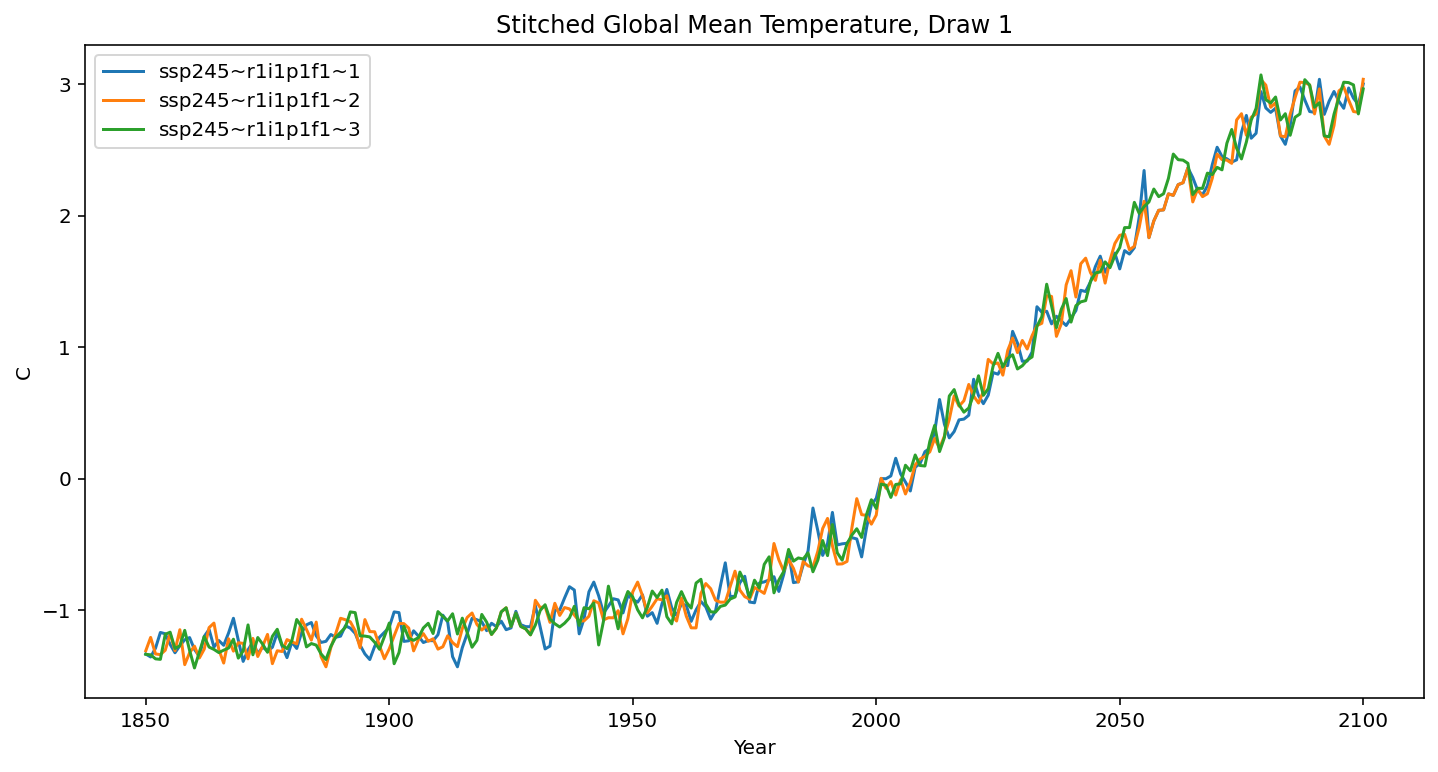

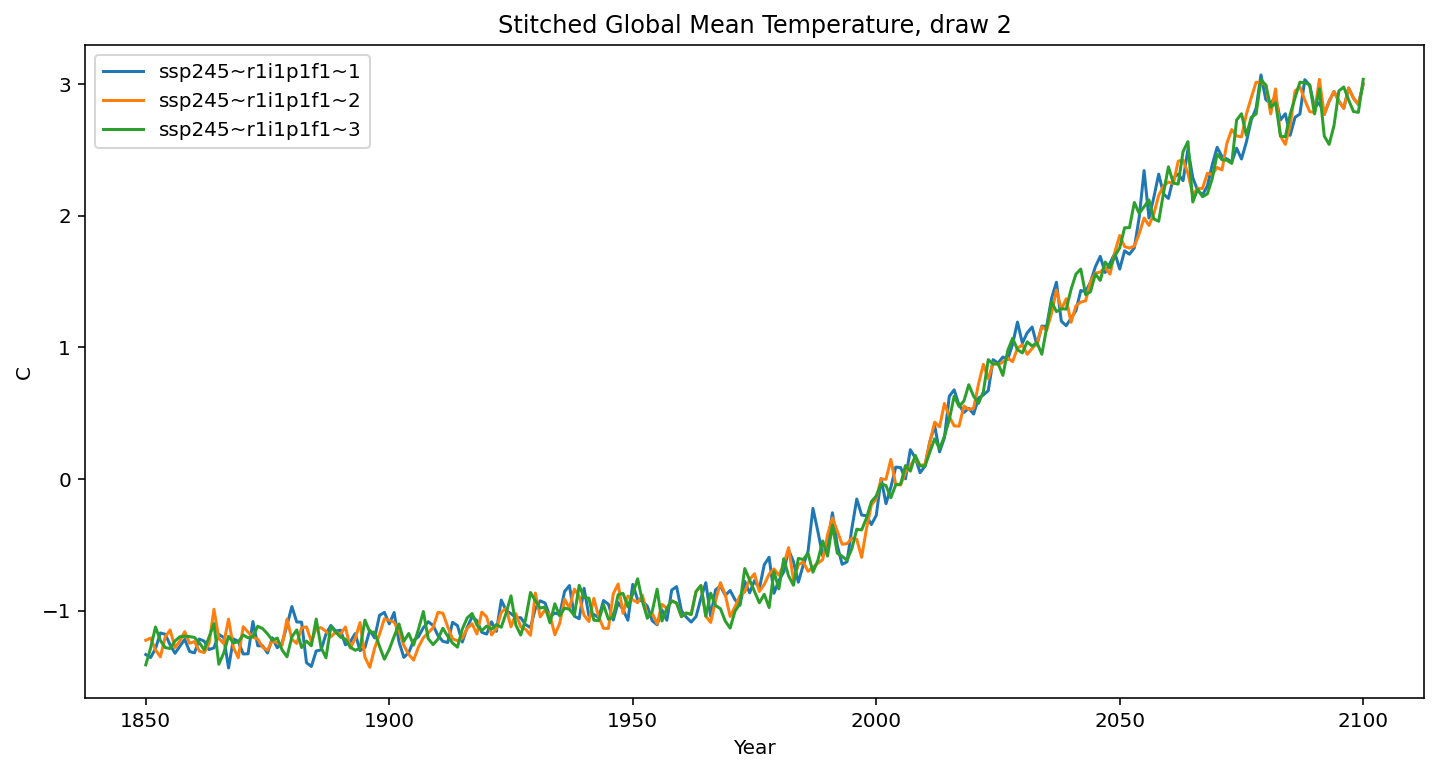

In [26]:
groups = stitched_global_temp_draw1.groupby('stitching_id')

for name, group in groups:
    plt.plot(group.year, group.value, label = name)

plt.xlabel("Year")
plt.ylabel("C")
plt.title("Stitched Global Mean Temperature, Draw 1")
plt.legend()
plt.show()
plt.close()


groups = stitched_global_temp_draw2.groupby('stitching_id')

for name, group in groups:
    plt.plot(group.year, group.value, label = name)

plt.xlabel("Year")
plt.ylabel("C")
plt.title("Stitched Global Mean Temperature, draw 2")
plt.legend()
plt.show()
plt.close()

# concatenate to a super-ensemble and plot

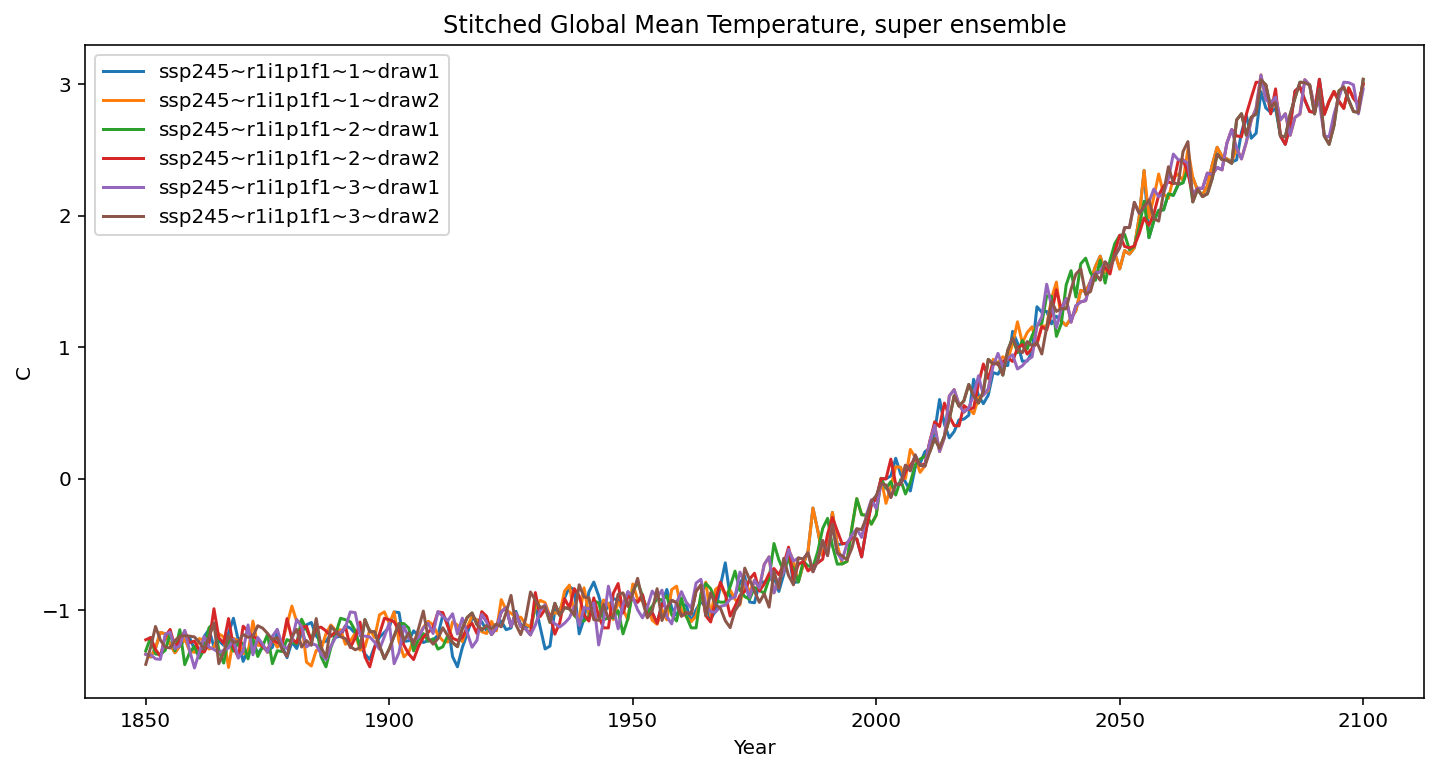

In [27]:
#update the stitching ids to reflect draws
stitched_global_temp_draw1['stitching_id'] = stitched_global_temp_draw1['stitching_id'] + '~draw1'
stitched_global_temp_draw2['stitching_id'] = stitched_global_temp_draw2['stitching_id'] + '~draw2'

# concatenate
super_ensemble = pd.concat([stitched_global_temp_draw1, stitched_global_temp_draw2]).reset_index(drop=True)

# plot
groups = super_ensemble.groupby('stitching_id')

for name, group in groups:
    plt.plot(group.year, group.value, label = name)

plt.xlabel("Year")
plt.ylabel("C")
plt.title("Stitched Global Mean Temperature, super ensemble")
plt.legend()
plt.show()
plt.close()

Again, around 2075, you can really see that there are not 6 distinct curves, and
the same trajectory is being followed for multiple ensemble members.


# Bonus example
When discussing pre-processing the archive data above, we emphasized not
wanting years of ESM data to be included in multiple archive windows.

Here, we will use the entire staggered archive, so every year appears in 9 total
archive windows. We will just look at the global average temperatures for
expediency,


In [28]:
# All windows for the experiments we want
full_staggered_archive = staggered_archive[(staggered_archive['model']== 'CanESM5')&
                                           (staggered_archive['experiment'].isin(['ssp126',
                                                                                  'ssp370', 'ssp585']))]

# make recipes
bad_recipes = stitches.make_recipe(target_data = target_data3,
                                  archive_data=full_staggered_archive,
                                  tol=0.06,
                                  N_matches=25,
                                  reproducible=True)
# stitch tgav
stitched_global_temp = stitches.gmat_stitching(bad_recipes)

You have requested more recipes than possible for at least one target trajectories, returning what can


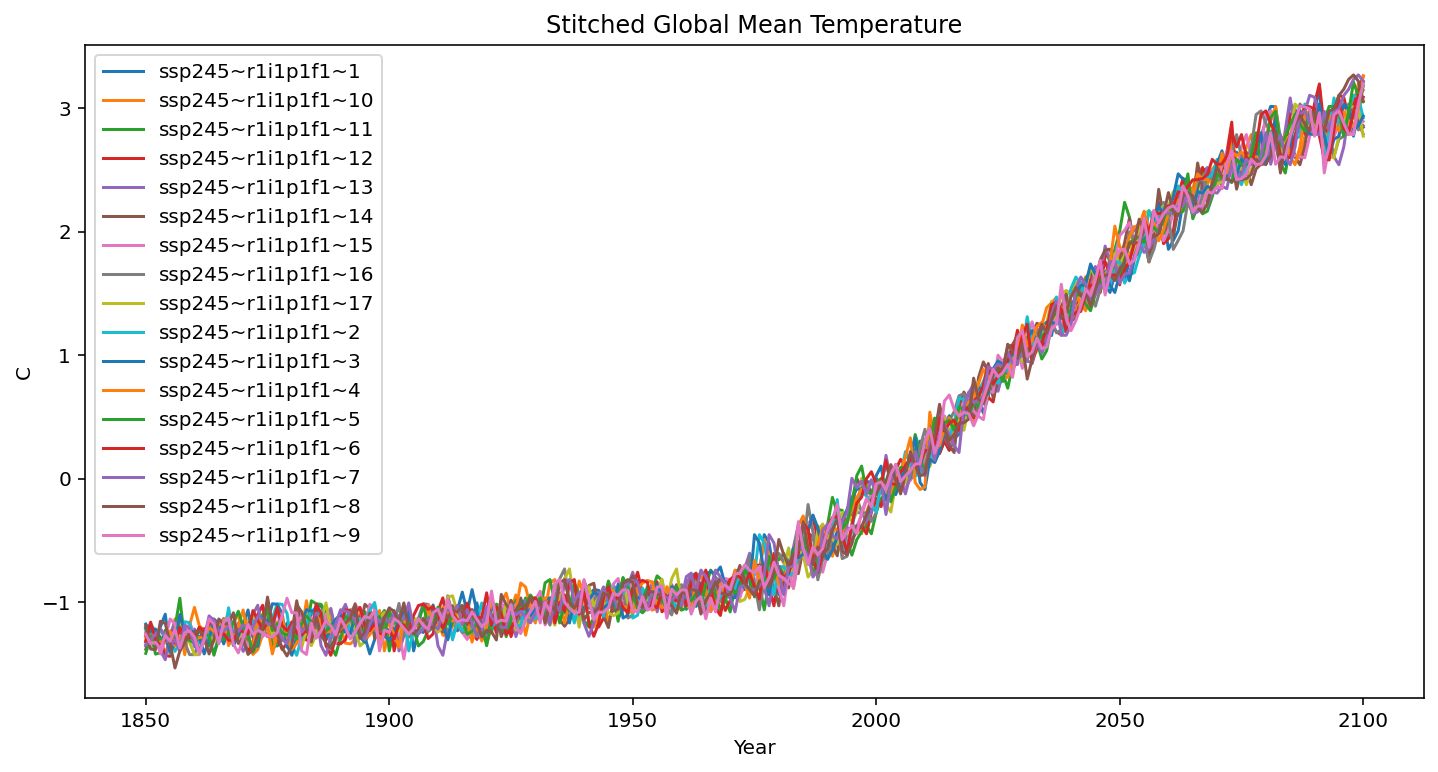

In [29]:
# plot

groups = stitched_global_temp.groupby('stitching_id')

for name, group in groups:
    plt.plot(group.year, group.value, label = name)

plt.xlabel("Year")
plt.ylabel("C")
plt.title("Stitched Global Mean Temperature")
plt.legend()
plt.show()
plt.close()

It's not necessarily easy to see, but if you look closely around 1975, you can see
several blue and purple curves that are obviously the same archive window offset
from each other  by a year or two. While this 'wave'  is NOT envelope collapse,
it's also not especially realistic. Having years only occur in 1-2 archive windows
helps prevent this from happening.


# Bonus 2!
What does a fully 'bad' match look like?
We can go far past the cutoff tolerance values provided in the paper to see

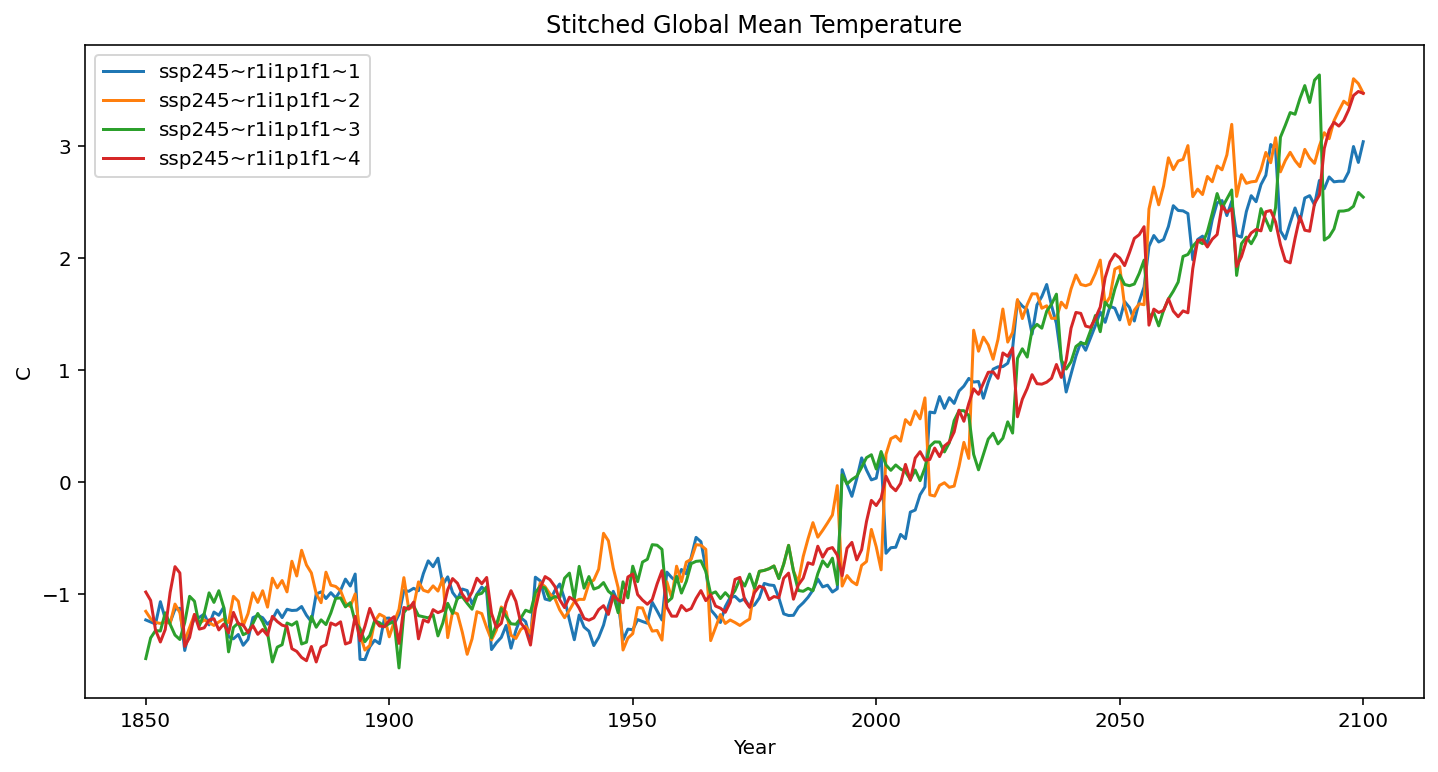

In [30]:
bad_recipes2 = stitches.make_recipe(target_data = target_data3,
                                  archive_data=archive_data,
                                  tol=0.5,
                                  N_matches=4,
                                  reproducible=True)
# stitch tgav
stitched_global_temp = stitches.gmat_stitching(bad_recipes2)

# plot
groups = stitched_global_temp.groupby('stitching_id')

for name, group in groups:
    plt.plot(group.year, group.value, label = name)

plt.xlabel("Year")
plt.ylabel("C")
plt.title("Stitched Global Mean Temperature")
plt.legend()
plt.show()
plt.close()

These curves (especially the red curve) are clearly rapidly switching between
archive scenarios as they sort of follow the target scenario's mean, rather than
matching the target scenario well.